<a href="https://colab.research.google.com/github/Qb2000/NTHU_2023_DLBOI_HW/blob/main/hw2/hw2_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">

# National Tsing Hua University

### Fall 2023

#### 11210IPT 553000

#### Deep Learning in Biomedical Optical Imaging

## Lab 3: Hyperparameter Tuning

</div>


In [ ]:
!nvidia-smi

Mon Oct 16 15:56:22 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.42                 Driver Version: 537.42       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   43C    P8               4W /  50W |   1920MiB /  4096MiB |      4%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# # Download dataset
!python -m wget  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy
!python -m wget  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy


Saved under normal.npy

Saved under pneumonia.npy


## A. Data Loading and Preprocessing

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

import numpy as np

# Load Dataset
abnormal_scans = np.load('pneumonia.npy')
normal_scans = np.load('normal.npy')

print(f'Shape of abnormal_scans: {abnormal_scans.shape}')
print(f'Shape of normal_scans: {normal_scans.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.

abnormal_labels = np.ones((abnormal_scans.shape[0],))
normal_labels = np.zeros((normal_scans.shape[0],))

split_point = 800

x_train = np.concatenate((abnormal_scans[:split_point], normal_scans[:split_point]), axis=0)
y_train = np.concatenate((abnormal_labels[:split_point], normal_labels[:split_point]), axis=0)
x_val = np.concatenate((abnormal_scans[split_point:], normal_scans[split_point:]), axis=0)
y_val = np.concatenate((abnormal_labels[split_point:], normal_labels[split_point:]), axis=0)

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).long()

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')
print(f'X_train: max value is {x_train.max().item()}, min value is {x_train.min().item()}, data type is {x_train.dtype}.')

Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.


## B. Defining Neural Networks in PyTorch

In [ ]:
import torch.nn as nn

model = nn.Sequential(
    nn.Flatten(),

    nn.Linear(256*256*1, 512),
    nn.BatchNorm1d(512),
#     nn.ReLU(),
#     nn.LeakyReLU(),
    nn.Sigmoid()
    nn.Dropout(0.9),

    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
#     nn.ReLU(),
#     nn.LeakyReLU(),
    nn.Sigmoid()
    nn.Dropout(0.9),

    nn.Linear(256, 256),
    nn.BatchNorm1d(256),
#     nn.ReLU(),
#     nn.LeakyReLU(),
    nn.Sigmoid()
    nn.Dropout(0.8),

    nn.Linear(256, 1)
).cuda()

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=512, bias=True)
  (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Dropout(p=0.9, inplace=False)
  (5): Linear(in_features=512, out_features=256, bias=True)
  (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Dropout(p=0.9, inplace=False)
  (9): Linear(in_features=256, out_features=256, bias=True)
  (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.01)
  (12): Dropout(p=0.8, inplace=False)
  (13): Linear(in_features=256, out_features=1, bias=True)
)


## C. Training the Neural Network

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR

train_losses1 = []
val_losses1 = []
train_accuracies1 = []
val_accuracies1 = []

epochs = 40
best_val_loss = float('inf')

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
# lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
# lr_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, total_iters=30)

for epoch in range(epochs):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.float().unsqueeze(1)
        # labels = labels.long()


        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        # total_loss += 1
        train_predicted = torch.sigmoid(outputs) > 0.5
        # train_predicted = outputs.argmax(-1)


        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.float().unsqueeze(1)
            # labels = labels.long()

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = torch.sigmoid(outputs) > 0.5
            # predicted = outputs.argmax(-1)


            correct += (predicted.float() == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'model_classification.pth')

    # Store performance
    train_losses1.append(avg_train_loss)
    train_accuracies1.append(train_accuracy)
    val_losses1.append(avg_val_loss)
    val_accuracies1.append(val_accuracy)

Epoch 1/40, Train Loss: 0.7399, Train Accuracy: 53.75%, Val Loss: 0.6126, Val Accuracy: 78.50%
Epoch 2/40, Train Loss: 0.6138, Train Accuracy: 64.62%, Val Loss: 0.5027, Val Accuracy: 82.50%
Epoch 3/40, Train Loss: 0.5118, Train Accuracy: 75.75%, Val Loss: 0.3919, Val Accuracy: 86.00%
Epoch 4/40, Train Loss: 0.4116, Train Accuracy: 82.38%, Val Loss: 0.3501, Val Accuracy: 85.50%
Epoch 5/40, Train Loss: 0.3435, Train Accuracy: 86.06%, Val Loss: 0.2890, Val Accuracy: 86.25%
Epoch 6/40, Train Loss: 0.2909, Train Accuracy: 88.44%, Val Loss: 0.2321, Val Accuracy: 91.00%
Epoch 7/40, Train Loss: 0.2675, Train Accuracy: 89.56%, Val Loss: 0.1999, Val Accuracy: 93.75%
Epoch 8/40, Train Loss: 0.2630, Train Accuracy: 89.81%, Val Loss: 0.2324, Val Accuracy: 90.75%
Epoch 9/40, Train Loss: 0.2528, Train Accuracy: 91.31%, Val Loss: 0.2148, Val Accuracy: 90.75%
Epoch 10/40, Train Loss: 0.2379, Train Accuracy: 90.69%, Val Loss: 0.2203, Val Accuracy: 90.25%
Epoch 11/40, Train Loss: 0.2447, Train Accuracy: 

### Visualizing model performance

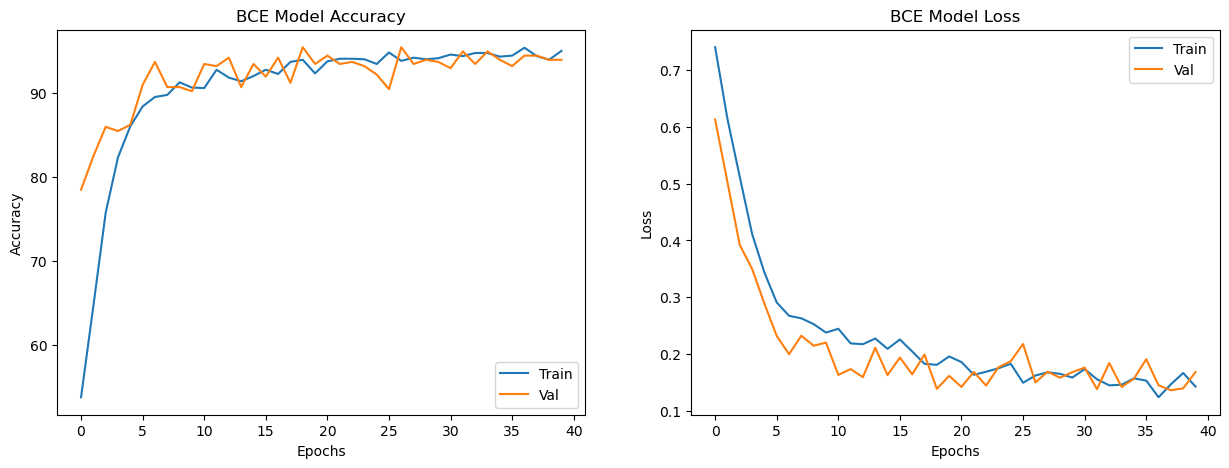

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies1)
ax[0].plot(val_accuracies1)
ax[0].set_title('BCE Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses1)
ax[1].plot(val_losses1)
ax[1].set_title('BCE Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

In [ ]:


model = nn.Sequential(
    nn.Flatten(),

    nn.Linear(256*256*1, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.9),

    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.9),

    nn.Linear(256, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.8),

    nn.Linear(256, 2)
).cuda()

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=512, bias=True)
  (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.9, inplace=False)
  (5): Linear(in_features=512, out_features=256, bias=True)
  (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.9, inplace=False)
  (9): Linear(in_features=256, out_features=256, bias=True)
  (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.8, inplace=False)
  (13): Linear(in_features=256, out_features=2, bias=True)
)


In [ ]:

train_losses2 = []
val_losses2 = []
train_accuracies2 = []
val_accuracies2 = []

epochs = 40
best_val_loss = float('inf')

# Criterion and Optimizer
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
# lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(epochs):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        # labels = labels.float().unsqueeze(1)
        labels = labels.long()


        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # train_predicted = torch.sigmoid(outputs) > 0.5
        train_predicted = outputs.argmax(-1)


        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model(images)

            # labels = labels.float().unsqueeze(1)
            labels = labels.long()

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            # predicted = torch.sigmoid(outputs) > 0.5
            predicted = outputs.argmax(-1)


            correct += (predicted.float() == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'model_classification.pth')

    # Store performance
    train_losses2.append(avg_train_loss)
    train_accuracies2.append(train_accuracy)
    val_losses2.append(avg_val_loss)
    val_accuracies2.append(val_accuracy)

Epoch 1/40, Train Loss: 0.7925, Train Accuracy: 52.38%, Val Loss: 0.6303, Val Accuracy: 70.00%
Epoch 2/40, Train Loss: 0.6850, Train Accuracy: 61.19%, Val Loss: 0.5666, Val Accuracy: 76.75%
Epoch 3/40, Train Loss: 0.5512, Train Accuracy: 70.75%, Val Loss: 0.4808, Val Accuracy: 79.25%
Epoch 4/40, Train Loss: 0.4947, Train Accuracy: 77.31%, Val Loss: 0.3733, Val Accuracy: 87.00%
Epoch 5/40, Train Loss: 0.3967, Train Accuracy: 83.62%, Val Loss: 0.3336, Val Accuracy: 85.75%
Epoch 6/40, Train Loss: 0.3607, Train Accuracy: 84.50%, Val Loss: 0.2731, Val Accuracy: 88.50%
Epoch 7/40, Train Loss: 0.3239, Train Accuracy: 86.81%, Val Loss: 0.2801, Val Accuracy: 87.00%
Epoch 8/40, Train Loss: 0.3048, Train Accuracy: 87.94%, Val Loss: 0.1982, Val Accuracy: 92.75%
Epoch 9/40, Train Loss: 0.2969, Train Accuracy: 88.44%, Val Loss: 0.2591, Val Accuracy: 87.25%
Epoch 10/40, Train Loss: 0.2683, Train Accuracy: 90.19%, Val Loss: 0.1852, Val Accuracy: 93.50%
Epoch 11/40, Train Loss: 0.2685, Train Accuracy: 

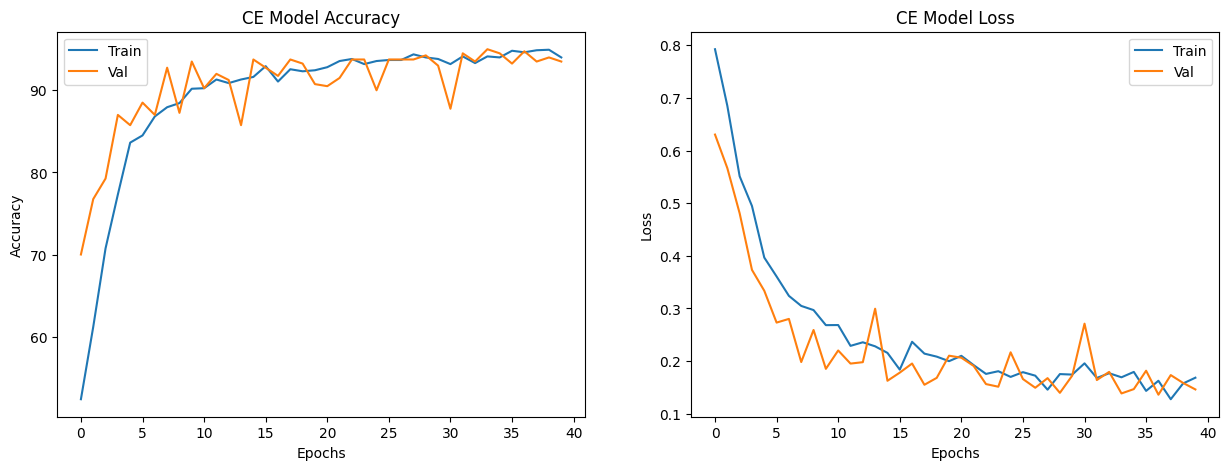

In [ ]:


fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies2)
ax[0].plot(val_accuracies2)
ax[0].set_title('CE Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses2)
ax[1].plot(val_losses2)
ax[1].set_title('CE Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

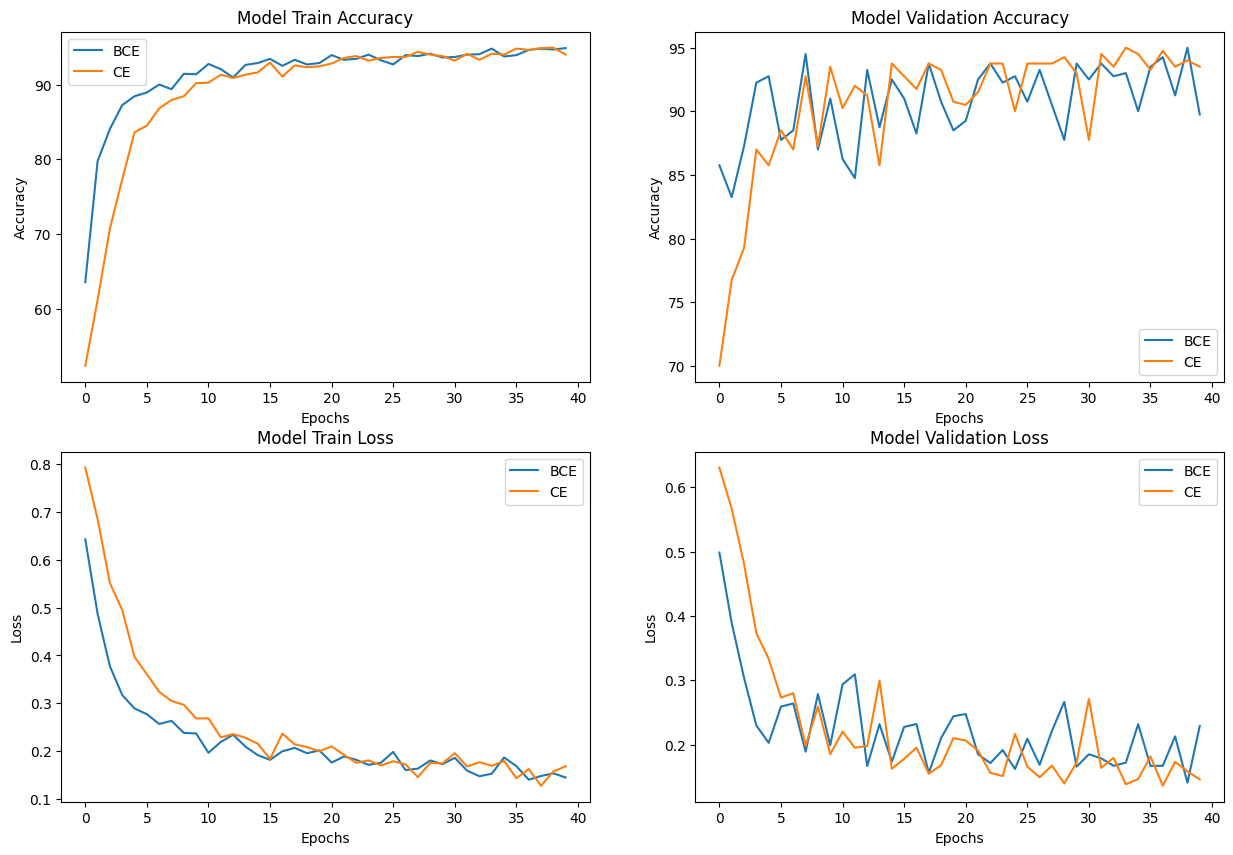

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Plotting training and validation accuracy
ax[0][0].plot(train_accuracies1)
ax[0][0].plot(train_accuracies2)
ax[0][0].set_title('Model Train Accuracy')
ax[0][0].set_xlabel('Epochs')
ax[0][0].set_ylabel('Accuracy')
ax[0][0].legend(['BCE', 'CE'])

ax[0][1].plot(val_accuracies1)
ax[0][1].plot(val_accuracies2)
ax[0][1].set_title('Model Validation Accuracy')
ax[0][1].set_xlabel('Epochs')
ax[0][1].set_ylabel('Accuracy')
ax[0][1].legend(['BCE', 'CE'])

ax[1][0].plot(train_losses1)
ax[1][0].plot(train_losses2)
ax[1][0].set_title('Model Train Loss')
ax[1][0].set_xlabel('Epochs')
ax[1][0].set_ylabel('Loss')
ax[1][0].legend(['BCE', 'CE'])

# Plotting training and validation loss
ax[1][1].plot(val_losses1)
ax[1][1].plot(val_losses2)
ax[1][1].set_title('Model Validation Loss')
ax[1][1].set_xlabel('Epochs')
ax[1][1].set_ylabel('Loss')
ax[1][1].legend(['BCE', 'CE'])

plt.show()